In [296]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

cvxopt_solvers.options['show_progress'] = False

(100, 2)


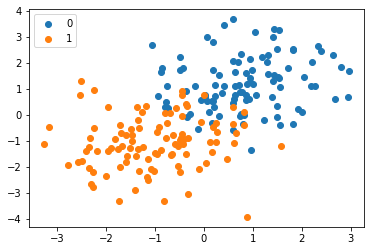

In [297]:
N = 200
X = np.zeros((N,2))
print(np.random.multivariate_normal(c1,np.eye(2,2),N//2).shape)
c1, c2 = [1,1], [-1,-1]
sigma = 1
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)
X_train = X[:200]
X_test = X[200:]
plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
plt.legend()


In [298]:

def distance_matrix(A, B, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared
    

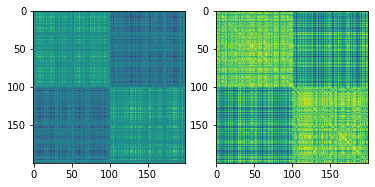

In [299]:
from scipy.spatial import distance

K = np.dot(X , X.T) * 1.
plt.subplot(121)
plt.imshow(K)

def get_RBF_K(A,B,RBF_sig=10):
    D = distance_matrix(A,B)
    K = np.exp(-D/2/RBF_sig**2)
    return K
    
plt.subplot(122)
K = get_RBF_K(X,X)
plt.imshow(K)


In [300]:

def SVM(K,Y,lmbda=1):
    N = K.shape[0]

    P = K
    G = np.vstack([np.eye(N,N),-np.eye(N,N)])

    C = 1/2/N/lmbda
    h = np.concatenate([np.repeat(C,N),np.repeat(0,N)])
    label = -1.*np.logical_not(Y)+1.*Y
    A = np.matrix(Y.astype(np.double))
    b = np.zeros(1)
    q = -np.ones(N)

    P = cvxopt_matrix(P)
    G =cvxopt_matrix(G)
    h =cvxopt_matrix(h)
    b =cvxopt_matrix(b)
    A =cvxopt_matrix(A)
    q =cvxopt_matrix(q)

    sol = cvxopt_solvers.qp(P=P, q=q, G=G, h=h, A=A, b=b, )
    alphas = np.array(sol['x'])

    return alphas

alphas = SVM(K,Y)

In [301]:
def pred(Z,X,alphas):
    gram = get_RBF_K(Z,X)
    return gram.dot(alphas)

def run_SVM_get_pred(X,Y,Z,lmbda = 1):
    K = get_RBF_K(X,X)
    alphas = SVM(K,Y,lmbda=lmbda)

    return pred(Z,X,alphas)

In [302]:
def run_SVM_and_plot_contours(X,Y,n_map = 100, double_side = False, lmbda = 1):

    x_min, x_max = np.min(X[:,0]),np.max(X[:,0])
    y_min, y_max = np.min(X[:,1]),np.max(X[:,1])

    x_r = np.linspace(x_min,x_max,n_map)
    y_r = np.linspace(y_min,y_max,n_map)
    x_r, y_r = np.meshgrid(x_r,y_r)
    x_r_, y_r_ = np.ndarray.flatten(x_r),np.ndarray.flatten( y_r)
    Z = np.vstack((x_r_,y_r_)).transpose()

    y = run_SVM_get_pred(X,Y,Z,lmbda = lmbda)
    if double_side:
        y = (y - run_SVM_get_pred(X,np.logical_not(Y),Z))/2

    plt.figure()
    plt.contourf(x_r, y_r, y.reshape(n_map,n_map), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
    plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
    plt.legend()    



(150, 2)


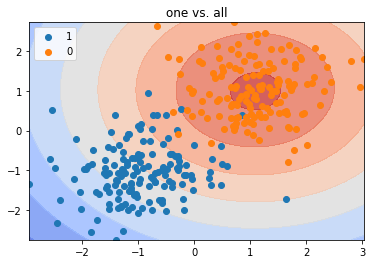

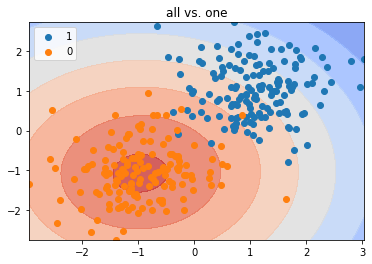

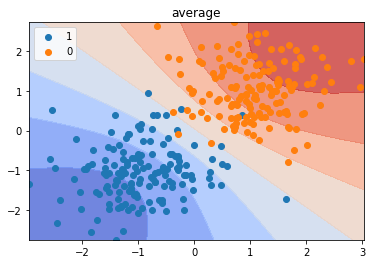

In [304]:

N = 300
X = np.zeros((N,2))
print(np.random.multivariate_normal(c1,np.eye(2,2),N//2).shape)
c1, c2 = [1,1], [-1,-1]
sigma = .5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)
X_train = X[:200]
X_test = X[200:]


run_SVM_and_plot_contours(X,Y)
plt.title('one vs. all')
plt.show()
run_SVM_and_plot_contours(X,np.logical_not(Y))
plt.title('all vs. one')
plt.show()
run_SVM_and_plot_contours(X,Y,double_side = True)
plt.title('average')
plt.show()
